# Building a CNN for Nature Classification

Welcome! The butterfly house next door has approached the botanical garden with a new idea: an app that can classify not just flowers, but also insects and small animals. Your task is to design and build the model that will make this possible.

This problem is more complex than what you’ve tackled before. The linear layers you used previously won’t be enough to capture the rich visual patterns in these diverse images. To meet this new challenge, you’ll build a **Convolutional Neural Network (CNN)**, a model designed to recognize shapes, textures, and features in visual data.

In this lab, you’ll go through the end-to-end process of building a CNN for this classification task. You’ll not only implement the architecture but also follow an iterative workflow—starting with a smaller prototype before scaling up—and learn how to diagnose common training issues.

You will:

* **Prepare a Diverse Dataset**: Load and transform a specialized subset of images for your multi-class nature classifier.

* **Build a CNN Architecture**: Define a complete CNN from scratch, combining convolutional, pooling, and fully connected layers to create a powerful feature extractor.

* **Train a Prototype Model**: Follow a realistic workflow by first training your model on a smaller, 9-class subset to build a working prototype and establish a performance baseline.

* **Scale Up and Diagnose Challenges**: Train the full model on all 15 classes and analyze the results to identify common machine learning challenges like overfitting.

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import helper_utils

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Preparing the Nature Dataset

For this lab, you'll work with a collection of images taken from the well-known [CIFAR-100 dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR100.html). This dataset is a fantastic resource for computer vision tasks, containing thousands of small, **32x32 color images** that are perfect for training a CNN. It’s a diverse collection, which is exactly what you need for the expanded nature classifier app.

While CIFAR-100 has 100 different classes, you won't need all of them. To meet the new requirements for your app, you'll focus on a curated selection of **15 classes** that fit the theme of a nature classifier. This selection will include flowers, insects and mammals. Specifically, you'll be working with:

* **Flowers**: 'orchid', 'poppy', 'rose', 'sunflower', 'tulip'

* **Mammals**: 'fox', 'porcupine', 'possum', 'raccoon', 'skunk'

* **Insects**: 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'


### Image Transformations

Before you load the dataset, first you need to define the transformation pipelines for it. Since all images in the dataset are already a standard **32x32** size, you don't need to add a resizing step. Your training pipeline will include data augmentation, while both pipelines will convert images to **tensors** and **normalize** them using the standard mean and standard deviation for the CIFAR-100 dataset.

* Define the specific mean and standard deviation for the CIFAR-100 dataset.

In [24]:
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

* Define two separate pipelines using `transforms.Compose`.
    * One for the training set that includes data augmentation and another for the validation set.

In [4]:
# Training set transformation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Validation set transformation pipeline
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

### Preparing the Data Pipeline

With your transformations ready, it's time to load the data. To quickly show the butterfly house next door a working prototype, it's a smart strategy to start with a smaller, more manageable dataset. This allows you to test your entire pipeline and build a baseline model without the long wait times required for the full dataset.

Therefore, instead of using all 15 classes at once, you'll begin with a balanced subset of **9 classes** (**3 from each category**). This iterative approach is a common and efficient practice in real-world machine learning.

For this initial prototype, you'll use the following classes:

* **Flowers**: 'orchid', 'poppy', 'sunflower'

* **Mammals**: 'fox', 'raccoon', 'skunk'

* **Insects**: 'butterfly', 'caterpillar', 'cockroach'

* Create a Python list containing the names of the 9 classes you'll use for the initial prototype.

In [5]:
subset_target_classes = [
    # Flowers
    'orchid', 'poppy', 'sunflower',
    # Mammals
    'fox', 'raccoon', 'skunk',
    # Insects
    'butterfly', 'caterpillar', 'cockroach'
]

* Use the `load_cifar100_subset` helper function, passing in your `subset_target_classes` list and both transformation pipelines.
* This function handles the entire loading process: it downloads the full CIFAR-100 dataset, applies your specified transformations, and then filters the result to include only the **9 classes** you selected.
* It returns the final training and validation dataset objects, ready for the next step.

In [6]:
# Call the helper function to prepare the datasets
train_dataset_proto, val_dataset_proto = helper_utils.load_cifar100_subset(subset_target_classes, train_transform, val_transform)

Dataset not found in './cifar_100'. Downloading...


100%|██████████| 169M/169M [00:38<00:00, 4.34MB/s] 


Dataset loaded successfully.

Filtering for 9 classes...
Filtering complete. Returning training and validation datasets.


* With your `Dataset` objects ready, the final step in the data pipeline is to create `DataLoaders`.

In [7]:
# Set the number of samples to be processed in each batch
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader_proto = DataLoader(train_dataset_proto, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling
val_loader_proto = DataLoader(val_dataset_proto, batch_size=batch_size, shuffle=False)

### Visualizing the Training Images

With your data pipeline complete, it's always a good idea to look at a few examples from your training set. This helps confirm that your data has been loaded and processed correctly. The following helper function will display a random sample of your training images.

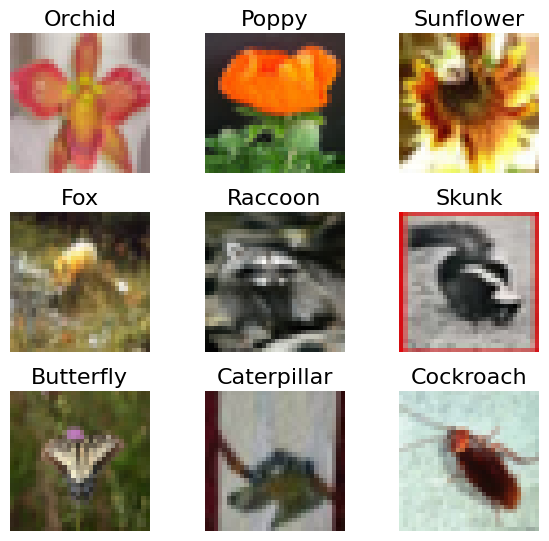

In [8]:
# Visualize a 3x3 grid of random training images
helper_utils.visualise_images(train_dataset_proto, grid=(3, 3))

## Building the CNN Architecture

With your data ready, it's time to build the core of your nature classifier. For a complex task like identifying different species in images, the linear layers you've used before aren't enough, as they look at pixels individually without understanding their spatial relationships.

You'll now build a **Convolutional Neural Network (CNN)**, an architecture specifically designed to "see" and recognize patterns, edges, and textures in images through a series of learnable filters. You'll define your model's structure using PyTorch's `nn.Module`, combining several types of layers to create a powerful image classifier.

Here's a breakdown of the key layers you'll use:

**Convolutional Layer (<code>[nn.Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)</code>)**
> This is the core building block of a CNN, using learnable filters to scan the image for visual features. The output is a set of "feature maps" that highlight where in the image these patterns appear.
> * `in_channels`: The number of channels from the previous layer; for the first layer, this is 3 for the RGB color channels.
> * `out_channels`: The number of filters the layer will learn, determining the number of output feature maps.
> * `kernel_size`: The dimensions of the filter, such as a 3x3 grid that examines a pixel and its immediate neighbors.
> * `padding`: Adds a border around the image, allowing the kernel to process edge pixels while preserving the image's dimensions.

**ReLU Activation Function (<code>[nn.ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code>)**
> An activation function that introduces non-linearity by changing all negative values in the feature maps to zero. This helps the model learn more complex patterns.

**Max Pooling Layer (<code>[nn.MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)</code>)**
> This layer downsamples the feature maps by reducing their height and width, which makes the network more efficient. It slides a window over the feature map and keeps only the single largest value from that window, discarding the rest.
> * `kernel_size`: The size of the window to perform pooling on, such as a 2x2 area.
> * `stride`: The step size the window moves across the image. A stride of 2 with a 2x2 kernel will halve the feature map's dimensions.

**Flatten Layer (<code>[nn.Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)</code>)**
> A utility layer that unrolls the 2D feature maps into a single 1D vector. This is a necessary step to prepare the data for the fully connected linear layers.

**Linear Layer (<code>[nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code>)**
> Also known as a fully connected layer, it performs the final classification. It combines the features learned by the convolutional layers into a final prediction.

**Dropout Layer (<code>[nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)</code>)**
> A regularization technique that helps prevent overfitting by randomly setting a fraction of neuron activations to zero during training. This forces the network to learn more robust features instead of relying too heavily on any single pattern.

In [9]:
class SimpleCNN(nn.Module):
    """
    A simple Convolutional Neural Network model.

    The architecture consists of three convolutional blocks followed by two
    fully connected layers for classification.
    """
    def __init__(self, num_classes):
        """
        Initializes the layers of the neural network.

        Args:
            num_classes: The number of output classes for the final layer.
        """
        # Call the constructor of the parent class (nn.Module)
        super(SimpleCNN, self).__init__()
        
        # Define the first convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Define the layer to flatten the feature maps
        self.flatten = nn.Flatten()

        # Define the fully connected (dense) layers
        # Input image is 32x32, after 3 pooling layers: 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        """
        Defines the forward pass of the model.

        Args:
            x: The input tensor of shape (batch_size, channels, height, width).

        Returns:
            The output tensor containing the logits for each class.
        """
        # Pass input through the first convolutional block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Pass feature maps through the second convolutional block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Pass feature maps through the third convolutional block
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = self.flatten(x)

        # Pass the flattened features through the fully connected layers
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Return the final output logits
        return x

With the `SimpleCNN` architecture defined, the next step is to create an instance of the model for your prototype.

* First, dynamically determine the number of output classes by checking the length of the class list in your `train_dataset_proto`.
* Create an instance of your `SimpleCNN`, passing `num_classes` to its constructor.

In [10]:
# Get the number of classes
num_classes = len(train_dataset_proto.classes)

# Instantiate the model
prototype_model = SimpleCNN(num_classes)

Before you start training, it's very helpful to visualize how the shape of your data changes as it flows through the CNN. This will confirm that your architecture is set up correctly and show you how the spatial dimensions shrink while the number of channels grows with each convolutional block.

* Define the `print_data_flow` helper function. 
    * This function will pass a sample 32x32 color image through your model, layer by layer, printing the tensor's shape at each key step to trace its journey from input to final prediction.

In [11]:
def print_data_flow(model):
    """
    Prints the shape of a tensor as it flows through each layer of the model.

    Args:
        model: An instance of the PyTorch model to inspect.
    """
    # Create a sample input tensor (batch_size, channels, height, width)
    x = torch.randn(1, 3, 32, 32)

    # Track the tensor shape at each stage
    print(f"Input shape: \t\t{x.shape}")

    # First conv block
    x = model.conv1(x)
    print(f"After conv1: \t\t{x.shape}")
    x = model.relu1(x)
    x = model.pool1(x)
    print(f"After pool1: \t\t{x.shape}")

    # Second conv block
    x = model.conv2(x)
    print(f"After conv2: \t\t{x.shape}")
    x = model.relu2(x)
    x = model.pool2(x)
    print(f"After pool2: \t\t{x.shape}")

    # Third conv block
    x = model.conv3(x)
    print(f"After conv3: \t\t{x.shape}")
    x = model.relu3(x)
    x = model.pool3(x)
    print(f"After pool3: \t\t{x.shape}")

    # Flatten using the model's flatten layer
    x = model.flatten(x)
    print(f"After flatten: \t\t{x.shape}")

    # Fully connected layers
    x = model.fc1(x)
    print(f"After fc1: \t\t{x.shape}")
    x = model.relu4(x)
    x = model.dropout(x)
    x = model.fc2(x)
    print(f"Output shape (fc2): \t{x.shape}")

You can now print a summary of your model and trace the data flow to see it in action.

* Call your helper function to print the tensor's shape at each step.

    * The tensor starts as a `(1, 3, 32, 32)` image. As it passes through the `conv` and `pool` blocks, the number of **channels increases** while the **spatial size is halved** at each step.

    * The final `(1, 128, 4, 4)` feature map is **flattened** into a 1D vector to be processed by the linear layers. The model's final **output shape is** `(1, 9)`, providing one score for each of the 9 classes.

In [12]:
# Print the model's architecture
print(prototype_model)

# Call the helper function to visualize the data flow
print("\n--- Tracing Data Flow ---")
print_data_flow(prototype_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

--- Tracing Data Flow ---
Input shape: 		torch.Size([1, 3, 32, 32])
After conv1: 		torch.Size([1, 32, 32, 32])
After pool1: 		torch.Size([1, 32, 16, 16])
After conv2: 		torch.Size([1, 64, 16, 16])
After pool2: 		t

## Training the Model

With your model defined and the data pipeline prepared, you're ready to set up the training process. This involves initializing a loss function to measure your model's error and an optimizer to update its weights based on that error.

### Initialize Loss Function and Optimizer

Before starting the training loop, you'll define two key components:

* You'll use <code>[nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)</code>. This is the standard loss function for multi-class classification tasks as it's designed to measure the error when a model has to choose one class from several possibilities.
* You'll use the <code>[Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)</code> optimizer. This is a popular and efficient algorithm that updates the model's weights to minimize the loss.

In [13]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer for the prototype model
optimizer_prototype = optim.Adam(prototype_model.parameters(), lr=0.001)

### The Training Loop

* Next, you'll define the `training_loop` function. This function encapsulates the entire process of training and validating your model over multiple epochs.

In [14]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Trains and validates a PyTorch neural network model.

    Args:
        model: The neural network model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        loss_function: The loss function to use for training.
        optimizer: The optimization algorithm.
        num_epochs: The total number of epochs to train for.
        device: The device (e.g., 'cpu' or 'cuda') to run the training on.

    Returns:
        A tuple containing:
        - The trained model.
        - A list of metrics [train_losses, val_losses, val_accuracies].
    """
    # Move the model to the specified device (CPU or GPU)
    model.to(device)
    
    # Initialize lists to store training and validation metrics
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Print a message indicating the start of the training process
    print("--- Training Started ---")
    
    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize running loss for the current epoch
        running_loss = 0.0
        # Iterate over batches of data in the training loader
        for images, labels in train_loader:
            # Move images and labels to the specified device
            images, labels = images.to(device), labels.to(device)
            
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Perform a forward pass to get model outputs
            outputs = model(images)
            # Calculate the loss
            loss = loss_function(outputs, labels)
            # Perform a backward pass to compute gradients
            loss.backward()
            # Update the model parameters
            optimizer.step()
            
            # Accumulate the training loss for the batch
            running_loss += loss.item() * images.size(0)
            
        # Calculate the average training loss for the epoch
        epoch_loss = running_loss / len(train_loader.dataset)
        # Append the epoch loss to the list of training losses
        train_losses.append(epoch_loss)
        
        # Set the model to evaluation mode
        model.eval()
        # Initialize running validation loss and correct predictions count
        running_val_loss = 0.0
        correct = 0
        total = 0
        # Disable gradient calculations for validation
        with torch.no_grad():
            # Iterate over batches of data in the validation loader
            for images, labels in val_loader:
                # Move images and labels to the specified device
                images, labels = images.to(device), labels.to(device)
                
                # Perform a forward pass to get model outputs
                outputs = model(images)
                
                # Calculate the validation loss for the batch
                val_loss = loss_function(outputs, labels)
                # Accumulate the validation loss
                running_val_loss += val_loss.item() * images.size(0)
                
                # Get the predicted class labels
                _, predicted = torch.max(outputs, 1)
                # Update the total number of samples
                total += labels.size(0)
                # Update the number of correct predictions
                correct += (predicted == labels).sum().item()
                
        # Calculate the average validation loss for the epoch
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # Append the epoch validation loss to the list
        val_losses.append(epoch_val_loss)
        
        # Calculate the validation accuracy for the epoch
        epoch_accuracy = 100.0 * correct / total
        # Append the epoch accuracy to the list
        val_accuracies.append(epoch_accuracy)
        
        # Print the metrics for the current epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_accuracy:.2f}%")
        
    # Print a message indicating the end of the training process
    print("--- Finished Training ---")
    
    # Consolidate all metrics into a single list
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Return the trained model and the collected metrics
    return model, metrics

With all the components in place, you're ready to start training.

* Run the `training_loop` function with your prototype model (for 9 classes), its corresponding data loaders, the loss function, and the optimizer. 
* You'll train for `15 epochs`, and the function will return the trained model along with the collected performance metrics.
* After training is complete, you'll use the `plot_training_metrics` helper function to visualize the training and validation loss, along with the validation accuracy. 

--- Training Started ---
Epoch [1/15], Train Loss: 1.7647, Val Loss: 1.3558, Val Accuracy: 50.11%
Epoch [2/15], Train Loss: 1.2730, Val Loss: 1.0689, Val Accuracy: 62.67%
Epoch [3/15], Train Loss: 1.0952, Val Loss: 0.9653, Val Accuracy: 66.78%
Epoch [4/15], Train Loss: 0.9873, Val Loss: 0.9369, Val Accuracy: 68.67%
Epoch [5/15], Train Loss: 0.9303, Val Loss: 0.8700, Val Accuracy: 70.11%
Epoch [6/15], Train Loss: 0.8319, Val Loss: 0.7955, Val Accuracy: 73.11%
Epoch [7/15], Train Loss: 0.7813, Val Loss: 0.7599, Val Accuracy: 76.11%
Epoch [8/15], Train Loss: 0.7241, Val Loss: 0.7481, Val Accuracy: 77.33%
Epoch [9/15], Train Loss: 0.6578, Val Loss: 0.7742, Val Accuracy: 76.11%
Epoch [10/15], Train Loss: 0.6305, Val Loss: 0.7428, Val Accuracy: 74.78%
Epoch [11/15], Train Loss: 0.6021, Val Loss: 0.6862, Val Accuracy: 77.78%
Epoch [12/15], Train Loss: 0.5486, Val Loss: 0.6517, Val Accuracy: 80.00%
Epoch [13/15], Train Loss: 0.5190, Val Loss: 0.7215, Val Accuracy: 75.89%
Epoch [14/15], Train L

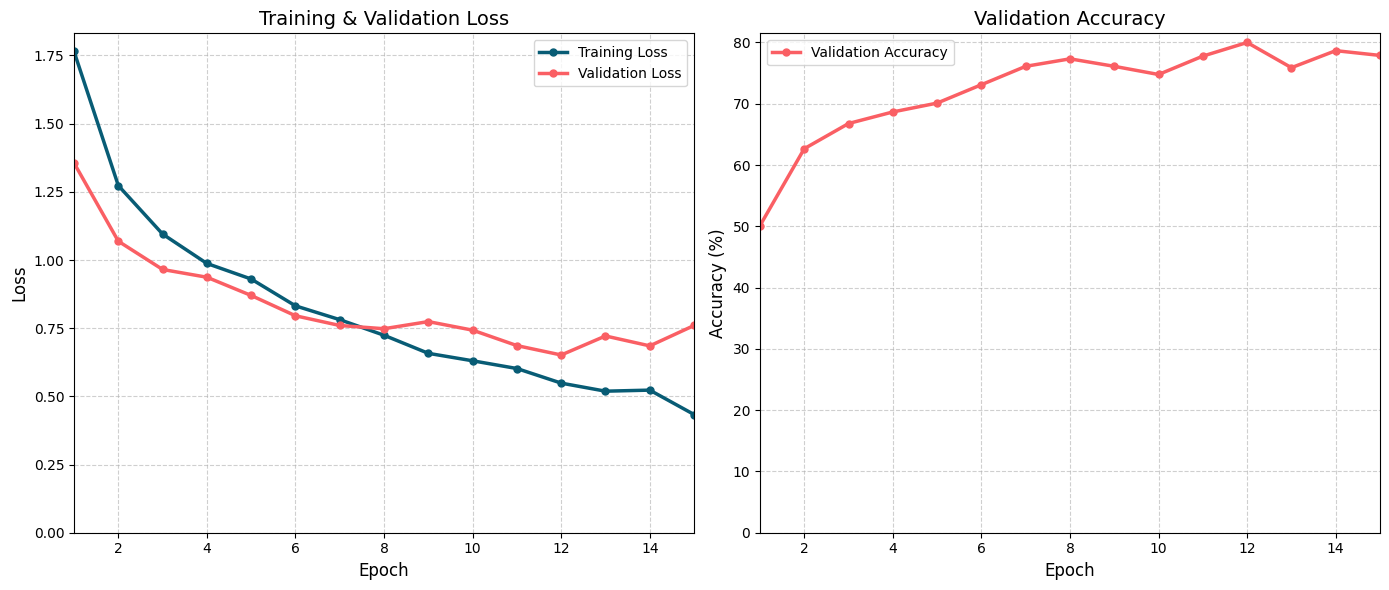

In [15]:
# Start the training process by calling the training loop function
trained_proto_model, training_metrics_proto = training_loop(
    model=prototype_model, 
    train_loader=train_loader_proto, 
    val_loader=val_loader_proto, 
    loss_function=loss_function, 
    optimizer=optimizer_prototype, 
    num_epochs=15, 
    device=device
)

# Visualize the training metrics (loss and accuracy)
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics_proto)

<br>

Excellent work! The prototype model is trained, and the results look very promising. Achieving a validation accuracy of over **75%** on the 9-class subset is a great result and confirms that your CNN architecture is well-suited for this task.

This successful prototype gives you the green light to move forward with the next phase: training a full-scale model on all 15 classes for the butterfly house. But before you do, it's helpful to perform one last qualitative check to see how your model "thinks."

### Visualizing Predictions

While the plots show your model's overall performance, looking at individual predictions provides a more intuitive feel for its strengths and weaknesses. You can now use a helper function to see your model in action, visualizing its predictions on random images from the validation set. This will show you concrete examples of where it succeeds and where it might be making mistakes.

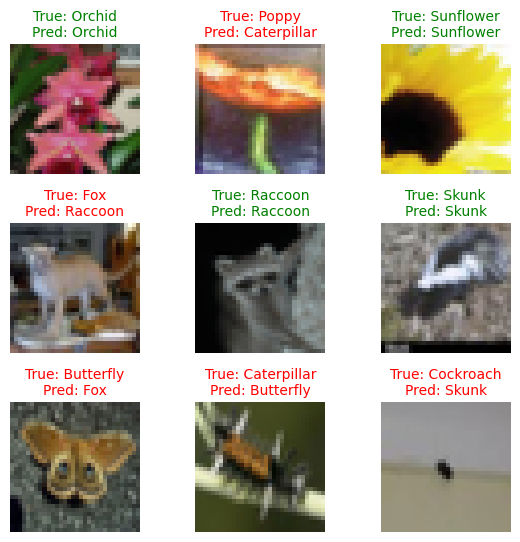

In [16]:
# Visualize model predictions on a sample of validation images
helper_utils.visualise_predictions(
    model=trained_proto_model, 
    data_loader=val_loader_proto, 
    device=device, 
    grid=(3, 3)
)

## Scaling Up: Training the Full Model 

The prototype was a success! Now it's time to train the final model for the butterfly house app. You'll repeat the same steps as before, but this time using the full, more challenging dataset of **15 classes**.

* First, create a new list containing all 15 target classes.
* Use the `load_cifar100_subset` helper function again to create the new training and validation datasets based on this full list.

In [17]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

* Wrap your new 15-class datasets in `DataLoader` instances, using the same `batch_size=64`.

In [18]:
# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

* Display a sample of images from your new 15-class training set to confirm it has been loaded correctly.

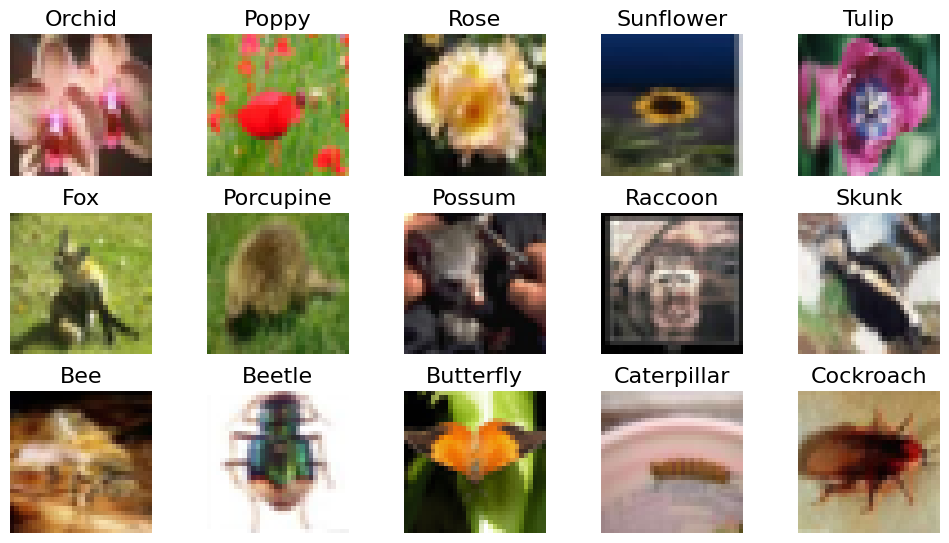

In [19]:
# Visualize a 3x5 grid of random training images
helper_utils.visualise_images(train_dataset, grid=(3, 5))

<br>

* Create a new instance of your `SimpleCNN` model, this time configured for all **15 classes**.

In [20]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the full model
model = SimpleCNN(num_classes)

# Print the model's architecture (notice, it now has 15 output classes)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


<br>

* Create a new `Adam` optimizer for your full 15-class model.

In [21]:
# Optimizer for the full model
optimizer = optim.Adam(model.parameters(), lr=0.001)

* Call the `training_loop` to train your 15-class model for `25 epochs`. The `plot_training_metrics` function will then immediately visualize the loss and accuracy curves from this final training run.

--- Training Started ---
Epoch [1/25], Train Loss: 2.1640, Val Loss: 1.7883, Val Accuracy: 40.53%
Epoch [2/25], Train Loss: 1.7633, Val Loss: 1.5708, Val Accuracy: 47.47%
Epoch [3/25], Train Loss: 1.5884, Val Loss: 1.4085, Val Accuracy: 52.60%
Epoch [4/25], Train Loss: 1.4870, Val Loss: 1.3938, Val Accuracy: 52.87%
Epoch [5/25], Train Loss: 1.3891, Val Loss: 1.3209, Val Accuracy: 56.60%
Epoch [6/25], Train Loss: 1.3011, Val Loss: 1.2809, Val Accuracy: 57.33%
Epoch [7/25], Train Loss: 1.2514, Val Loss: 1.1865, Val Accuracy: 60.27%
Epoch [8/25], Train Loss: 1.1776, Val Loss: 1.2016, Val Accuracy: 60.07%
Epoch [9/25], Train Loss: 1.1385, Val Loss: 1.1221, Val Accuracy: 61.73%
Epoch [10/25], Train Loss: 1.0664, Val Loss: 1.1165, Val Accuracy: 61.93%
Epoch [11/25], Train Loss: 1.0148, Val Loss: 1.0788, Val Accuracy: 64.80%
Epoch [12/25], Train Loss: 0.9867, Val Loss: 1.0441, Val Accuracy: 65.40%
Epoch [13/25], Train Loss: 0.9354, Val Loss: 1.0593, Val Accuracy: 64.60%
Epoch [14/25], Train L

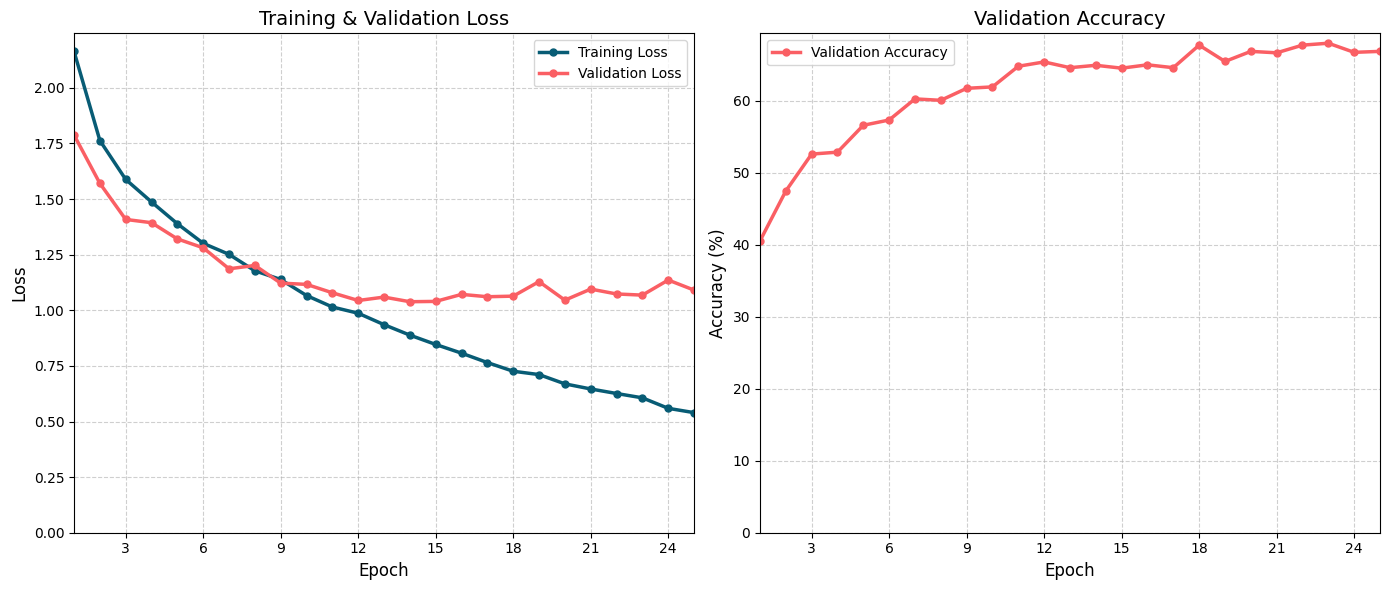

In [22]:
# Start the training process for the full model on all 15 classes
trained_model, training_metrics = training_loop(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=25, 
    device=device
)

# Visualize the training metrics for the full model
print("\n--- Training Plots ---\n")
helper_utils.plot_training_metrics(training_metrics)

<br>

After training the full model, you can analyze the results. But wait, something isn't right here. Your prototype model trained successfully, showing steady improvement. However, the performance on the full 15-class dataset seems to have hit a wall. What happened?

A close look at the plots reveals the problem. While the **Training Loss** consistently decreases, the **Validation Loss** drops for a while and then begins to rise and fluctuate. At the same time, the **Validation Accuracy** gets stuck, plateauing without making further significant progress. This is a classic case of **overfitting**.

Overfitting occurs when a model learns the training data *too well*, including its noise and specific quirks, instead of the general, underlying patterns that would help it perform on new, unseen data. The widening gap between your training and validation loss is a clear sign your model is memorizing the training set instead of learning to **generalize**.

You might wonder why this happened now and not with the 9-class prototype. The reason is the significant increase in **task complexity**. Distinguishing between 15 classes is much harder than 9, requiring the model to learn more subtle features. Faced with this harder challenge, your powerful CNN model found an easier path to lowering the training loss: it started to memorize the training data instead of learning to generalize.

This overfitting problem presents a realistic challenge, similar to what you'd encounter in a real-world project. In this module's graded assignment, you'll tackle this issue by making several updates to your entire pipeline to see if you can improve the model's ability to generalize.

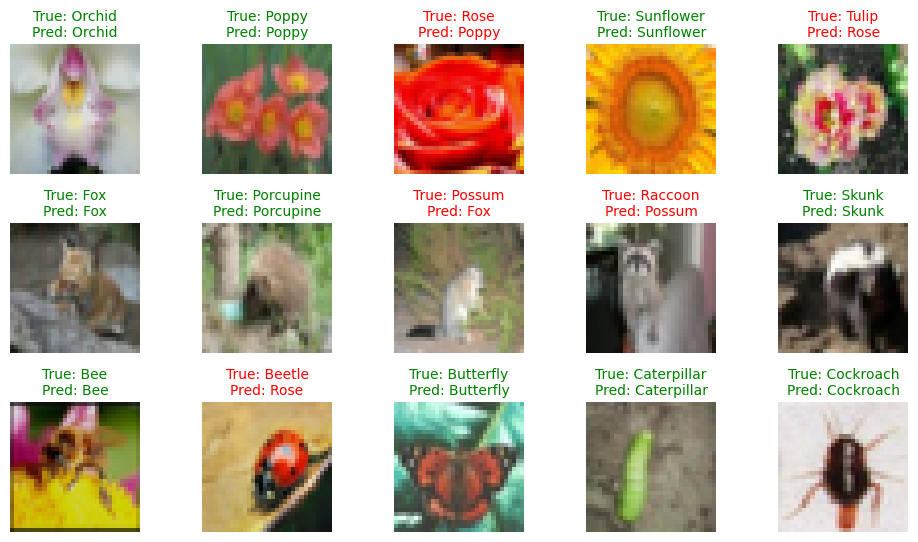

In [25]:
# ### Optional: Uncomment and run this cell to see the predictions made by the full model

helper_utils.visualise_predictions(
    model=trained_model, 
    data_loader=val_loader, 
    device=device, 
    grid=(3, 5)
)

## Conclusion

Congratulations on completing the lab! You have successfully navigated the entire machine learning pipeline, from data preparation to building, training, and analyzing your very own Convolutional Neural Network.

You've put theory into practice by building a CNN architecture capable of learning complex visual patterns. More importantly, you've experienced a realistic, iterative development workflow by first creating a successful prototype and then scaling up to a more complex model. This process led you to encounter and diagnose overfitting, a fundamental challenge that every machine learning practitioner must learn to solve.

The skills you've developed here have prepared you for the next step. You've identified the problem, and in the graded assignment, you'll get to solve it. Well done!